In [ ]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

import numpy as np
from Simulation.projections_util import Objective, create_neat_proj, create_projections, create_paper_objectives, create_milp_projection
from Data.data_load_util import make_dataset
from Data.data_manager import DataManager
from scipy.optimize import milp, LinearConstraint, Bounds
from Models.MILP.milp_util import MilpModel

In [ ]:
zips_df, state_df, pos_df = make_dataset(granularity='both', remove_outliers=False, load_dir_prefix='../../Data/')
data_manager = DataManager(zips_df, fields=['carbon_offset_metric_tons_per_panel', 'yearly_sunlight_kwh_kw_threshold_avg'])

num_zips = len(zips_df)
num_panels = 2000000

#objective weights
weights = [1, 1, np.float64(1.487431321576903), 1]

In [ ]:
#my API for MILP
save_path = "../../Simulation/Projection_Saves/projections_milp_2m.pkl"
model = MilpModel(weights)
milp_projection = create_milp_projection(data_manager, num_panels, model, create_paper_objectives())#, save=save_path)#, load=save_path)

Status: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Objective value: -1.5472125841923001


{'Carbon Offset': {0: 0.0, np.float64(2000000.0): np.float64(354913.8542633846)}, 'Energy Potential': {0: 0.0, np.float64(2000000.0): np.float64(2716183087.6553593)}, 'Racial Equity': {0: np.float64(1.3610811038452764), np.float64(2000000.0): np.float64(1.6436933228814954)}, 'Income Equity': {0: np.float64(1.0009989598234297), np.float64(2000000.0): np.float64(1.8108181717996716)}}
Loading from previous simulation...
Loading from previous calculations...


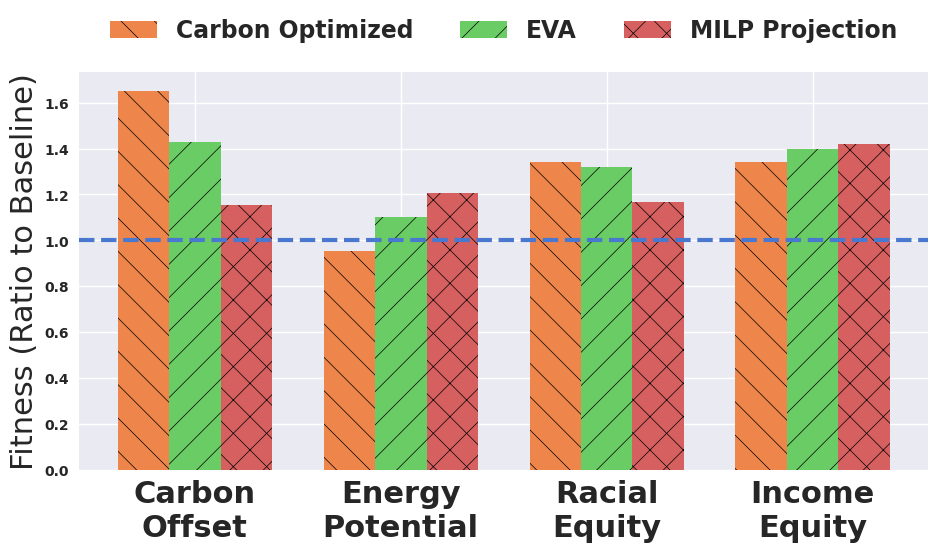

In [ ]:
#print milp projection
from Visualization.projection_plots import plot_bar_comparison_ratio


print(milp_projection.objective_projections)

#visualize vs other models
proj_path_2m = "../../Simulation/Projection_Saves/projections_2m.pkl"
projections_2m = create_projections(zips_df, state_df, n_panels=2000000, save=proj_path_2m, load=proj_path_2m)

neat_proj_path_2m = "../../Simulation/Projection_Saves/projections_neat_2m.pkl"
neat_proj_new_2m = create_neat_proj(data_manager, 2000000, None, create_paper_objectives(), load=neat_proj_path_2m)

plot_bar_comparison_ratio(projections_2m[1], [projections_2m[2], neat_proj_new_2m, milp_projection], panel_count=num_panels, hatches=["\\","/","x"], hatch_size=0.5, fontsize=22)

Raw code for the milp

In [ ]:
#prepare constants
energy_potential_by_zip = data_manager.normalized_df['yearly_sunlight_kwh_kw_threshold_avg'].values
carbon_offset_by_zip = data_manager.normalized_df['carbon_offset_metric_tons_per_panel'].values

#high black prop flag
black_prop_median = zips_df['black_prop'].median()
zips_df['black_prop_flag'] = 0
zips_df.loc[zips_df['black_prop'] > black_prop_median, 'black_prop_flag'] = 1
high_black_prop_flag = zips_df['black_prop_flag'].values

#high income flag
income_median = zips_df['Median_income'].median()
zips_df['income_flag'] = 0
zips_df.loc[zips_df['Median_income'] > income_median, 'income_flag'] = 1
high_income_flag = zips_df['income_flag'].values

In [ ]:
#TEST RUN WITH NO EQUITY
#optimize num panels in each zip
# zip_placements = [weights[0] * energy_potential_by_zip[i]/num_panels + 
#                weights[1] * carbon_offset_by_zip[i]/num_panels for i in range(num_zips)]

# zip_placement_bounds = data_manager.combined_df['count_qualified'].values

# total_objective = -np.array(zip_placements)

# # Variable bound
# bounds = Bounds(np.array([0 for i in range(num_zips)]), np.array(zip_placement_bounds))

# # Constraints matrix and bounds
# A = np.array([
#     [1 for i in range(num_zips)] # sum of total panels is num_panels
# ])
# lb = np.array([num_panels])
# ub = np.array([num_panels])
# constraints = LinearConstraint(A, lb, ub)

# # Integer constraint
# integrality = np.array([1 for i in range(num_zips)])  # 1 = integer, 0 = continuous

# # Solve MILP
# res = milp(c=total_objective, constraints=constraints, integrality=integrality, bounds=bounds)

# # Output result
# print("Status:", res.message)
# print("Objective value:", res.fun)
# print("x =", res.x)


In [ ]:
#optimize num panels in each zip
zip_placements = [weights[0] * energy_potential_by_zip[i]/num_panels + 
               weights[1] * carbon_offset_by_zip[i]/num_panels for i in range(num_zips)]

zip_placement_bounds = data_manager.combined_df['count_qualified'].values.tolist()
#aux vars for abs val when calculating equity
auxilliary_vars = [-weights[2]/num_panels, -weights[3]/num_panels]

total_objective = -np.array(zip_placements + auxilliary_vars)

# Variable bound
bounds = Bounds([0 for i in range(num_zips + 2)], zip_placement_bounds+ [np.inf, np.inf])

# Constraints matrix and bounds
A = np.array([
    [1 for i in range(num_zips)] + [0, 0], # sum of total panels is num_panels
    
    [-2 * high_black_prop_flag[i] for i in range(num_zips)] + [1, 0], #racial aux constraint
    [2 * high_black_prop_flag[i] for i in range(num_zips)] + [1, 0],

    [-2 * high_income_flag[i] for i in range(num_zips)] + [0, 1], #equity aux constraint
    [2 * high_income_flag[i] for i in range(num_zips)] + [0, 1], #equity aux constraint
])
lb = np.array([num_panels, -num_panels, num_panels, -num_panels, num_panels])
ub = np.array([num_panels, np.inf, np.inf, np.inf, np.inf])
constraints = LinearConstraint(A, lb, ub)

# Integer constraint
integrality = np.array([1 for i in range(num_zips)] + [0, 0])  # 1 = integer, 0 = continuous

# Solve MILP
res = milp(c=total_objective, constraints=constraints, integrality=integrality, bounds=bounds)

# Output result
print("Status:", res.message)
print("Objective value:", res.fun)
print("x =", res.x)


Status: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Objective value: -1.5472125841923001
x = [0. 0. 0. ... 0. 0. 0.]


In [ ]:
#calculate the objectives for the generated placement
panel_placements = {zips_df['region_name'][i]: res.x[i] for i in range(num_zips)}

# projections = init_objective_projs(zip_df,objectives)

num_panels = sum(panel_placements.values()) #total panels
objectives = create_paper_objectives()

for objective in objectives:
    print(objective.name, objective.calc(zips_df, panel_placements))

Carbon Offset 354913.8542633846
Energy Potential 2716183087.6553593
Racial Equity 1.6436933228814954
Income Equity 1.8108181717996716


In [ ]:
import pickle
with open("test_milp_placement.pkl", "wb") as f:
    pickle.dump(panel_placements, f)